<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Kaggle Project: Dstl Satellite Imagery Feature Detection
# Name: Jianlei(John) Sun
# Beginning Date: January 21, 2017

In [3]:
from collections import defaultdict
import csv
import sys
import time

import cv2
from shapely.geometry import MultiPolygon, Polygon
## conda install shapely
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
## pip install tifffile
import pandas as pd

from shapely.wkt import loads as wkt_loads
from matplotlib.patches import Patch
# from matplotlib.patches import Polygon, Patch

# decartes package makes plotting with holes much easier
from descartes.patch import PolygonPatch
## pip install descartes

import matplotlib.pyplot as plt
import tifffile as tiff
%matplotlib inline 

from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.externals import joblib

import xgboost as xgb
## http://xgboost.readthedocs.io/en/latest/build.html

from IPython.core.debugger import Tracer

# Functions

In [4]:
## Adapted based on Konstantin Lopuhin's Kaggle script:
## https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly/discussion


## Define classes and corresponding colours - for plotting
CLASSES = {
        1 : 'Buildings',
        2 : 'Misc',
        3 : 'Road',
        4 : 'Track',
        5 : 'Trees',
        6 : 'Crops',
        7 : 'Waterway',
        8 : 'Standing water',
        9 : 'Vehicle Large',
        10 : 'Vehicle Small',
        }

COLORS = {
        1 : '0.7',
        2 : '0.4',
        3 : '#b35806',
        4 : '#dfc27d',
        5 : '#1b7837',
        6 : '#a6dba0',
        7 : '#74add1',
        8 : '#4575b4',
        9 : '#f46d43',
        10: '#d73027',
        }
ZORDER = {
        1 : 5,
        2 : 5,
        3 : 4,
        4 : 1,
        5 : 3,
        6 : 2,
        7 : 7,
        8 : 8,
        9 : 9,
        10: 10,
        }    

## Load training polygons
train_wkt = pd.read_csv('./train_wkt_v4.csv')

## Load sample submission
sample_submission = pd.read_csv('./sample_submission.csv')

## Load grid size
grid_sizes = pd.read_csv('./grid_sizes.csv')
grid_sizes.columns = ['ImageId','Xmax','Ymin']

def get_scalers(image_size, x_max, y_min):
# To provide scalers that will be used to scale predicted polygons    
    
    h, w = image_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


## Convert polygons to mask
def mask_for_polygons(polygons, image_size):
    image_mask = np.zeros(image_size, np.uint8)
    if not polygons:
        return image_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(image_mask, exteriors, 1)
    cv2.fillPoly(image_mask, interiors, 0)
    return image_mask

# scale "M" and "A" to "P" images
def func_feature_scale(imageName, numRows, numCols):
    
    data = tiff.imread(imageName)
    data = data.transpose([1, 2, 0])
    nr, nc, nlayer = data.shape[0], data.shape[1], data.shape[2]
    out = np.zeros(shape = (numRows, numCols, nlayer), dtype='uint16')
    
    for i in range(nlayer):
        
        dataArray = data[:,:,i]
        rowRatio = round(numRows/nr) 
        colRatio = round(numCols/nc)
        for j in range(nr-1):
            for k in range(nc-1):
                out[j*rowRatio:(j+1)*rowRatio, k*colRatio:(k+1)*colRatio, i] = dataArray[j,k]
                
        # for j == nr-1 & k < nc-1
        for k in range(nc-1):
            out[(nr-1)*rowRatio:, k*colRatio:(k+1)*colRatio, i] = dataArray[nr-1,k]
            
        # for k == nc-1 & j < nr-1
        for j in range(nr-1):
            out[j*rowRatio:(j+1)*rowRatio, (nc-1)*colRatio:, i] = dataArray[j,nc-1]
            
        # for k == nc-1 & j == nr-1
        out[(nr-1)*rowRatio:,(nc-1)*colRatio:,i] = dataArray[-1, -1]
        
    return out

## Convert image to training data: X and y
def image_to_train(image_id, class_type, image_type ='3'):
    
    # Read "M" + "A" + "P" bands or "RGB" band
    if image_type =='3':
        image = tiff.imread('./three_band/{}.tif'.format(image_id)).transpose([1, 2, 0])
        X = image.reshape(-1, 3).astype(np.float32) 
        image_size = image.shape[:2]
    else:
        X_P = tiff.imread('./sixteen_band/{}_P.tif'.format(image_id))
        nomRow = X_P.shape[0]
        nomCol = X_P.shape[1]
        
#        Tracer()()
        imageMP = func_feature_scale('./sixteen_band/{}_M.tif'.format(image_id), nomRow, nomCol)
        X_M = imageMP.reshape(-1, 8).astype(np.float32) 

        imageAP = func_feature_scale('./sixteen_band/{}_A.tif'.format(image_id), nomRow, nomCol)
        X_A = imageAP.reshape(-1, 8).astype(np.float32)    
        
        X_P = X_P.reshape(-1, 1).astype(np.float32)    
        X = np.hstack((X_A, X_M, X_P))  
        image_size = [nomRow, nomCol]
    
    # Get grid size: x_max and y_min
    x_max = grid_sizes[grid_sizes['ImageId']==image_id].Xmax.values[0]
    y_min = grid_sizes[grid_sizes['ImageId']==image_id].Ymin.values[0]
    
    # Load train poly with shapely
    train_polygons = shapely.wkt.loads(train_wkt[(train_wkt['ImageId']==image_id) & 
                                                (train_wkt['ClassType']==class_type)].MultipolygonWKT.values[0])
    # Scale polygons
    x_scaler, y_scaler = get_scalers(image_size, x_max, y_min)
    train_polygons_scaled = shapely.affinity.scale(train_polygons,
                                                   xfact=x_scaler,
                                                   yfact=y_scaler,
                                                   origin=(0, 0, 0))
    train_mask = mask_for_polygons(train_polygons_scaled, image_size)
    y = train_mask.reshape(-1)    

    return X, y, train_polygons

def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    # epsilon:  maximum distance from contour to approximated contour
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def image_to_test(image_id, image_type='3'):
    if image_type =='3':
        image = tiff.imread('./three_band/{}.tif'.format(image_id)).transpose([1, 2, 0])
        image_shape = image.shape[0:2]
        X = image.reshape(-1, 3).astype(np.float32)
    else:
        X_P = tiff.imread('./sixteen_band/{}_P.tif'.format(image_id))
        nomRow = X_P.shape[0]
        nomCol = X_P.shape[1]
        
        imageMP = func_feature_scale('./sixteen_band/{}_M.tif'.format(image_id), nomRow, nomCol)
        X_M = imageMP.reshape(-1, 8).astype(np.float32) 

        imageAP = func_feature_scale('./sixteen_band/{}_A.tif'.format(image_id), nomRow, nomCol)
        X_A = imageAP.reshape(-1, 8).astype(np.float32)    
        
        X_P = X_P.reshape(-1, 1).astype(np.float32)    
        X = np.hstack((X_A, X_M, X_P))  
        image_shape = [nomRow, nomCol]
        
    return X, image_shape


## Load/ merge/ convert training images into a single table
def load_train_pixels(class_type, image_type = '3', val_ids = None):
    start = time.time()
    
    image_ids = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
    train_x = np.array([])
    train_y = np.array([])
    if len(val_ids): ## peserved image ids for validation 
        for i in val_ids:
            image_ids.remove(i)
    print (len(image_ids),image_ids)
    
    print ("Loading data for class type %d" % (class_type))
    
    for image_id in image_ids:
        x, y, p = image_to_train(image_id, class_type, image_type)
        if image_type == 'withLabel':
            x = x[y == 1]
            y = y[y == 1]
        elif image_type == 'withoutLabel': 
            x = x[y == 0]
            y = y[y == 0]   
            
        if len(train_x)==0:  ## initialize train_x
            train_x = x
        else:                ## append new image to train_x
            train_x = np.vstack((train_x,x))

        if len(train_y)==0:  ## initialize train_y with x
            train_y = y
        else:                ## append new data to train_y
            train_y = np.hstack((train_y,y))
        
    print ("Data loaded in %d seconds." % (time.time() - start), train_x.shape, train_y.shape)
    
    return train_x, train_y  

def train_class(X, y, class_type, n_jobs=-1):
    pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log', n_jobs=n_jobs))
#     pipeline = make_pipeline(StandardScaler(), LogisticRegression(n_jobs=n_jobs))
    start = time.time()
    print('training...')
    pipeline.fit(X, y)
    print('training finished in %d seconds' % (time.time()-start))
    return pipeline

def train_pixel_models(class_types):
    clfs = dict()
    for class_type in class_types:
        print (class_type, class_types[class_type])
        train_x, train_y = load_train_pixels(class_type=class_type, image_type='3')    
        clfs[class_type] = train_class(train_x, train_y, class_type=class_type, n_jobs=-1)
    return clfs


def predict_class(image_id, clf, threshold = 0.05, image_type = '3', epsilon = 10., min_area = 10.):
    ## Get test data
    test_x, test_image_shape = image_to_test(image_id, image_type)
    ## Make predictions
#     print ("Predicting....")
    pred_y = clf.predict_proba(test_x)[:, 1]

    ## Convert predictions to mask
    pred_mask = pred_y.reshape(test_image_shape)
#     pred_mask.shape

    ## Convert mask to polygonsx
    pred_mask = pred_mask >= threshold
    pred_polygons = mask_to_polygons(pred_mask, epsilon = 10., min_area = 10.)
    pred_poly_mask = mask_for_polygons(pred_polygons,test_image_shape)

    ## Scale polygons based on image's grid size
    test_x_max = grid_sizes[grid_sizes['ImageId']==image_id].Xmax.values[0]
    test_y_min = grid_sizes[grid_sizes['ImageId']==image_id].Ymin.values[0]    

    test_x_scaler, test_y_scaler = get_scalers(test_image_shape, test_x_max, test_y_min)

    scaled_pred_polygons = shapely.affinity.scale(
        pred_polygons, xfact=1 / test_x_scaler, yfact=1 / test_y_scaler, origin=(0, 0, 0))

    ## Convert polygons to WKT format
    pred_wkt = shapely.wkt.dumps(scaled_pred_polygons)
    # print (scaled_pred_polygons,shapely.wkt.dumps(scaled_pred_polygons))
    pred_polygons = shapely.wkt.loads(pred_wkt)
    return pred_y, pred_wkt, pred_polygons


def get_train_polygons(image_id,classes = CLASSES):
    train_wkt = pd.read_csv('./train_wkt_v4.csv')
    WKTs = train_wkt[train_wkt.ImageId == image_id]
    polygonsList = {}
    for cType in classes.keys():
        polygonsList[cType] = wkt_loads(WKTs[WKTs.ClassType == cType].MultipolygonWKT.values[0])
    return polygonsList


def plot_polygons(polygonsList, image_id, figsize=(10, 10)):
    '''
    Plot descrates.PolygonPatch from list of polygons objs for each CLASS
    '''
    legend_patches = []
    fig, axArr = plt.subplots(figsize=figsize)
    ax = axArr
    for cType in polygonsList:
#         print('{} : {} \tcount = {}'.format(cType, CLASSES[cType], len(polygonsList[cType])))
        legend_patches.append(Patch(color=COLORS[cType],
                                    label='{} ({})'.format(CLASSES[cType], len(polygonsList[cType]))))
        for polygon in polygonsList[cType]:
            mpl_poly = PolygonPatch(polygon,
                                    color=COLORS[cType],
                                    lw=0,
                                    alpha=0.7,
                                    zorder=ZORDER[cType])
            ax.add_patch(mpl_poly)
    # ax.relim()
    ax.autoscale_view()
    ax.set_title('Objects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(handles=legend_patches,
#            loc='upper left',
           bbox_to_anchor=(0.9, 1),
           bbox_transform=plt.gcf().transFigure,
           ncol=5,
           fontsize='x-small',
           title='Objects-' + image_id,
           # mode="expand",
           framealpha=0.3)
    #return legend_patches

# Give short names, sensible colors and zorders to object types

def unique_rows(data):
    uniq = np.unique(data.view(data.dtype.descr * data.shape[1]))
    return uniq.view(data.dtype).reshape(-1, data.shape[1])


# Train Each ClassType


In [5]:
CLASSES

{1: 'Buildings',
 2: 'Misc',
 3: 'Road',
 4: 'Track',
 5: 'Trees',
 6: 'Crops',
 7: 'Waterway',
 8: 'Standing water',
 9: 'Vehicle Large',
 10: 'Vehicle Small'}

## 1_Buildings

In [8]:
class_type = 1

# data with labels
val_image_id = []
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => 6100_1_3 + 6110_1_2 + 6120_2_2 + 6140_1_2
val_image_id = ['6060_2_3', '6070_2_3', '6100_2_2', '6100_2_3', '6110_3_1', '6110_4_0', '6120_2_0', '6140_3_1']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x_wl, train_y_wl.reshape([-1,1]))))
train_x_wl = t[:,:-1]
train_y_wl = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x_wl.shape, train_y_wl.shape)

# 2_Misc data without labels =>
val_image_id = ['6100_1_3', '6110_1_2', '6120_2_2', '6140_1_2']
train_x_misc, train_y_misc = load_train_pixels(class_type = 2, val_ids = val_image_id, image_type = 'withLabel')
train_y_misc = np.array([0] * len(train_y_misc))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_misc))
train_y = np.hstack((train_y, train_y_wl, train_y_misc))

del train_x_wl, train_y_wl, train_x_misc, train_y_misc
print ("Data Shape: ", train_x.shape, train_y.shape)

12 ['6120_2_2', '6120_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6060_2_3', '6070_2_3', '6100_2_2']
Loading data for class type 1
Data loaded in 91 seconds. (10048655, 17) (10048655,)
4 ['6120_2_2', '6100_1_3', '6110_1_2', '6140_1_2']
Loading data for class type 1
Data loaded in 34 seconds. (38735272, 17) (38735272,)
Removing Duplicated Data ...
Data loaded in 183 seconds. (31214396, 17) (31214396,)
13 ['6120_2_0', '6090_2_0', '6110_4_0', '6140_3_1', '6100_2_3', '6150_2_3', '6110_3_1', '6170_2_4', '6170_0_4', '6060_2_3', '6070_2_3', '6010_1_2', '6100_2_2']
Loading data for class type 2
Data loaded in 91 seconds. (1097612, 17) (1097612,)
Data Shape:  (42360663, 17) (42360663,)


In [9]:
class_type = 1

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 1 finishied in 862 seconds...
Training AUC:  0.929675681844


In [7]:
## optimize threshold values

class_type = 1

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

#threshold = [0.35, 0.38, 0.39, 0.4, 0.45]
#[0.3920642614756121, 0.39339047290520235, 0.39356247325909904, 0.41501704250496824, 0.4070869945909983]
threshold = [0.40]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
         
        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


Self-intersection at or near point 3047.5991379310344 3170.9181034482758


imageId = 6060_2_3, threshold = 0.4000, jaccard score = 0.0871, InterArea = 3.6394e-08, UnionArea = 4.1803e-07


Self-intersection at or near point 3327.8458781362006 140.55913978494624


imageId = 6070_2_3, threshold = 0.4000, jaccard score = 0.0800, InterArea = 7.2513e-07, UnionArea = 9.0686e-06


Self-intersection at or near point 2873.4000000000001 1947.2


imageId = 6100_1_3, threshold = 0.4000, jaccard score = 0.3732, InterArea = 3.5760e-06, UnionArea = 9.5828e-06


Self-intersection at or near point 3155.7307692307691 1540.8923076923077


imageId = 6100_2_2, threshold = 0.4000, jaccard score = 0.2861, InterArea = 1.3015e-06, UnionArea = 4.5496e-06


Self-intersection at or near point 3016.6842105263158 664.68421052631584


imageId = 6100_2_3, threshold = 0.4000, jaccard score = 0.4663, InterArea = 3.5906e-06, UnionArea = 7.6995e-06


Self-intersection at or near point 2179.8215661103977 678.80744544287552


imageId = 6110_1_2, threshold = 0.4000, jaccard score = 0.5289, InterArea = 7.1648e-06, UnionArea = 1.3547e-05


Self-intersection at or near point 2512.039076376554 1583.7140319715809


imageId = 6110_3_1, threshold = 0.4000, jaccard score = 0.3785, InterArea = 3.1004e-06, UnionArea = 8.1914e-06


Self-intersection at or near point 3314.9893292682927 43.951219512195124


imageId = 6110_4_0, threshold = 0.4000, jaccard score = 0.3305, InterArea = 1.6191e-06, UnionArea = 4.8982e-06


Self-intersection at or near point 3086.7246596066566 471.05597579425114


imageId = 6120_2_0, threshold = 0.4000, jaccard score = 0.2866, InterArea = 5.1865e-07, UnionArea = 1.8099e-06


Self-intersection at or near point 3370.8499999999999 1783


imageId = 6120_2_2, threshold = 0.4000, jaccard score = 0.5379, InterArea = 1.0734e-05, UnionArea = 1.9954e-05


Self-intersection at or near point 2069.7295423023579 1033.7683772538142


imageId = 6140_1_2, threshold = 0.4000, jaccard score = 0.5060, InterArea = 7.3187e-06, UnionArea = 1.4463e-05


Self-intersection at or near point 2608.765625 944.3125


imageId = 6140_3_1, threshold = 0.4000, jaccard score = 0.3513, InterArea = 3.2921e-06, UnionArea = 9.3726e-06
Averaged Jaccard Score =  [0.41501704250496824]


## 2_Misc

In [7]:
class_type = 2

# data with labels
val_image_id = []
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => 6100_1_3 + 6110_1_2 + 6120_2_2 + 6140_1_2
val_image_id = ['6010_1_2', '6060_2_3', '6070_2_3', '6090_2_0', '6100_2_2', '6100_2_3', '6110_3_1', 
                '6110_4_0', '6120_2_0', '6140_3_1', '6150_2_3', '6170_0_4', '6170_2_4']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x_wl, train_y_wl.reshape([-1,1]))))
train_x_wl = t[:,:-1]
train_y_wl = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x_wl.shape, train_y_wl.shape)

# 1_building data without labels =>
val_image_id = ['6120_2_2', '6100_1_3', '6110_1_2', '6140_1_2']
train_x_building, train_y_building = load_train_pixels(class_type = 1, val_ids = val_image_id, image_type = 'withLabel')
train_y_building = np.array([0] * len(train_y_building))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_building))
train_y = np.hstack((train_y, train_y_wl, train_y_building))

del train_x_wl, train_y_wl, train_x_building, train_y_building
print ("Data Shape: ", train_x.shape, train_y.shape)

17 ['6120_2_2', '6120_2_0', '6090_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6150_2_3', '6140_1_2', '6110_3_1', '6170_2_4', '6170_0_4', '6060_2_3', '6070_2_3', '6010_1_2', '6100_2_2']
Loading data for class type 2
Data loaded in 140 seconds. (2580620, 17) (2580620,)
4 ['6120_2_2', '6100_1_3', '6110_1_2', '6140_1_2']
Loading data for class type 2
Data loaded in 43 seconds. (44002920, 17) (44002920,)
Removing Duplicated Data ...
Data loaded in 216 seconds. (35473394, 17) (35473394,)
8 ['6120_2_0', '6110_4_0', '6140_3_1', '6100_2_3', '6110_3_1', '6060_2_3', '6070_2_3', '6100_2_2']
Loading data for class type 1
Data loaded in 64 seconds. (3297999, 17) (3297999,)
Data Shape:  (41352013, 17) (41352013,)


In [8]:
class_type = 2

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 200, max_depth = 6, 
                                                             subsample = 0.8, colsample_bytree = 0.8))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 2 finishied in 2462 seconds...
Training AUC:  0.843498943891


In [9]:
## optimize threshold values

class_type = 2

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

threshold = [0.07]

# threshold = [0.06, 0.07, 0.08, 0.09]
# jaccard_list = [0.018843579950017487, 0.019413928612292977, 0.01633060995452238, 0.014783841263104712]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                        threshold = i, image_type = 'withLabel', epsilon = 1., min_area = 10.)
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
        t = val_p.area
        # handle "Error performing intersection: TopologyException: found non-noded intersection"
        val_p = val_p.simplify(1e-8, preserve_topology=False) 
        val_p = shapely.wkt.dumps(val_p,rounding_precision = 8)
        val_p = shapely.wkt.loads(val_p)
        if not val_p.is_valid:
            val_p = val_p.buffer(0)

        print('Validation Area {:.8e} => {:.8e}'.format(t, val_p.area))
        
        pred_val_p = pred_val_p.simplify(1e-8, preserve_topology=False)
        pred_val_p = shapely.wkt.dumps(pred_val_p,rounding_precision = 8)
        pred_val_p = shapely.wkt.loads(pred_val_p)
        if not pred_val_p.is_valid:
            pred_val_p = pred_val_p.buffer(0)
        
        t = pred_val_p.union(val_p).area
        if t!= 0:
            print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
                  .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / t, 
                    pred_val_p.intersection(val_p).area, t))
        else:
            print('imageId = {:^8}, threshold = {:.4f}, InterArea = {:.4e}, ZERO!! UnionArea = {:.4e}'
                  .format(val_image_id[j], i, pred_val_p.intersection(val_p).area, t))            
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  




Self-intersection at or near point 2139.9495548961422 44.468842729970326
Ring Self-intersection at or near point 0.0088730000000000007 -0.005816


Validation Area 5.41695000e-08 => 5.41695000e-08
imageId = 6010_1_2, threshold = 0.0700, jaccard score = 0.0007, InterArea = 5.4170e-08, UnionArea = 8.2529e-05


Self-intersection at or near point 3068.3333333333335 3174


Validation Area 2.52385698e-07 => 2.52387114e-07
imageId = 6060_2_3, threshold = 0.0700, jaccard score = 0.0031, InterArea = 2.5203e-07, UnionArea = 8.1640e-05


Self-intersection at or near point 3268.8240963855424 2733.4987951807229
Self-intersection at or near point 0.0077710418058940288 -0.0089950524081099416


Validation Area 2.50966668e-07 => 2.50968495e-07
imageId = 6070_2_3, threshold = 0.0700, jaccard score = 0.0029, InterArea = 2.1931e-07, UnionArea = 7.4518e-05


Self-intersection at or near point 3055.3033033033034 3027.996996996997


Validation Area 2.84457489e-08 => 2.84457016e-08


Self-intersection at or near point 0.0040549100000000001 -0.0086094399999999995


imageId = 6090_2_0, threshold = 0.0700, jaccard score = 0.0004, InterArea = 2.8446e-08, UnionArea = 7.9248e-05


Self-intersection at or near point 3340.072837632777 2244.9468892261002
Self-intersection at or near point 0.0047379778000534029 -0.0051287653021313308


Validation Area 2.26053172e-06 => 2.26052365e-06


Ring Self-intersection at or near point 0.0032950800000000001 -0.0050896700000000001


imageId = 6100_1_3, threshold = 0.0700, jaccard score = 0.0909, InterArea = 1.6970e-06, UnionArea = 1.8673e-05


Self-intersection at or near point 3312.9719101123596 918.11516853932585


Validation Area 6.78303088e-07 => 6.78304650e-07


Ring Self-intersection at or near point 0.0054882000000000004 -0.0045196500000000001


imageId = 6100_2_2, threshold = 0.0700, jaccard score = 0.0524, InterArea = 4.4635e-07, UnionArea = 8.5201e-06


Self-intersection at or near point 3336.0196078431372 50.862745098039213
Self-intersection at or near point 0.00849500056348239 -0.0051420007751021273


Validation Area 1.16881727e-06 => 1.17155469e-06


Ring Self-intersection at or near point 0.0084778000000000006 -0.00058894999999999998


imageId = 6100_2_3, threshold = 0.0700, jaccard score = 0.0552, InterArea = 7.7031e-07, UnionArea = 1.3945e-05


Self-intersection at or near point 3373.1333333333332 1304.2666666666667
Self-intersection at or near point 0.0033809599999999997 -0.0045389499999999999


Validation Area 2.37327678e-06 => 2.36132784e-06


Ring Self-intersection at or near point 0.0022956000000000001 -0.00134235


imageId = 6110_1_2, threshold = 0.0700, jaccard score = 0.0799, InterArea = 1.8253e-06, UnionArea = 2.2838e-05


Self-intersection at or near point 3389.6421052631581 335.92631578947368
Self-intersection at or near point 0.00013501000000000021 -0.0062042699999999996


Validation Area 1.04171158e-06 => 1.04171526e-06
imageId = 6110_3_1, threshold = 0.0700, jaccard score = 0.0381, InterArea = 8.1350e-07, UnionArea = 2.1374e-05


Self-intersection at or near point 3380.0526315789475 309.94736842105266
Ring Self-intersection at or near point 0.0083160000000000005 -8.6000000000000003e-05


Validation Area 4.75418515e-07 => 4.75419013e-07
imageId = 6110_4_0, threshold = 0.0700, jaccard score = 0.0207, InterArea = 3.7366e-07, UnionArea = 1.8054e-05


Self-intersection at or near point 3399.8858218318696 1424.1405269761606
Self-intersection at or near point 0.0053820098504003475 -0.00035383343190488486


Validation Area 6.03151704e-07 => 6.03537283e-07
imageId = 6120_2_0, threshold = 0.0700, jaccard score = 0.0233, InterArea = 5.2763e-07, UnionArea = 2.2652e-05


Self-intersection at or near point 3396.4000000000001 557.79999999999995
Self-intersection at or near point 0.0051980000000000004 -0.00020599766627771296


Validation Area 1.69450306e-06 => 1.69512678e-06
imageId = 6120_2_2, threshold = 0.0700, jaccard score = 0.0469, InterArea = 1.0338e-06, UnionArea = 2.2025e-05


Self-intersection at or near point 3355.2758620689656 1416.844827586207
Self-intersection at or near point 0.0057256144343664789 -0.00018967766586908534


Validation Area 2.03099107e-06 => 2.03098735e-06
imageId = 6140_1_2, threshold = 0.0700, jaccard score = 0.0552, InterArea = 1.6638e-06, UnionArea = 3.0158e-05


Self-intersection at or near point 3390.9126807563962 1851.8081201334817
Self-intersection at or near point 0.0040721799999999999 -0.00653529


Validation Area 1.19004957e-06 => 1.19004105e-06


Ring Self-intersection at or near point 0.0042884899999999998 -0.0068795599999999998


imageId = 6140_3_1, threshold = 0.0700, jaccard score = 0.0362, InterArea = 9.1930e-07, UnionArea = 2.5376e-05


Self-intersection at or near point 3359.3155818540436 614.91321499013804


Validation Area 5.03241449e-07 => 5.03243397e-07


Self-intersection at or near point 0.0058065499999999997 -0.00067252000000000002


imageId = 6150_2_3, threshold = 0.0700, jaccard score = 0.0105, InterArea = 4.9120e-07, UnionArea = 4.6827e-05


Self-intersection at or near point 3383.9589895988115 1662.6731054977711


Validation Area 1.36260046e-09 => 1.36264960e-09
imageId = 6170_0_4, threshold = 0.0700, jaccard score = 0.0000, InterArea = 1.2387e-09, UnionArea = 7.2526e-05


Self-intersection at or near point 3134.1851851851852 2438.8148148148148


Validation Area 8.78500000e-10 => 8.78500000e-10
imageId = 6170_2_4, threshold = 0.0700, jaccard score = 0.0000, InterArea = 8.7850e-10, UnionArea = 7.7299e-05
Averaged Jaccard Score =  [0.015480164370652309]


Self-intersection at or near point 2855.0809061488671 1400.8025889967637
Ring Self-intersection at or near point 0.0088730000000000007 -0.005816


Validation Area 5.41695000e-08 => 5.41695000e-08
imageId = 6010_1_2, threshold = 0.0300, jaccard score = 0.0007, InterArea = 5.4065e-08, UnionArea = 8.1702e-05
Validation Area 2.52385698e-07 => 2.52387114e-07
imageId = 6060_2_3, threshold = 0.0300, jaccard score = 0.0031, InterArea = 2.5224e-07, UnionArea = 8.1397e-05


Self-intersection at or near point 2695.1403887688984 2929.0712742980563
Self-intersection at or near point 0.0077710418058940288 -0.0089950524081099416


Validation Area 2.50966668e-07 => 2.50968495e-07
imageId = 6070_2_3, threshold = 0.0300, jaccard score = 0.0030, InterArea = 2.3396e-07, UnionArea = 7.8932e-05


Self-intersection at or near point 3360.2743259085582 2974.5252051582647


Validation Area 2.84457489e-08 => 2.84457016e-08
imageId = 6090_2_0, threshold = 0.0300, jaccard score = 0.0004, InterArea = 2.8446e-08, UnionArea = 7.2739e-05


Self-intersection at or near point 3387.6340956340955 1979.5426195426196
Self-intersection at or near point 0.0047379778000534029 -0.0051287653021313308


Validation Area 2.26053172e-06 => 2.26052365e-06
imageId = 6100_1_3, threshold = 0.0300, jaccard score = 0.0406, InterArea = 2.1871e-06, UnionArea = 5.3894e-05


Self-intersection at or near point 3334.1408450704225 1451.9859154929577


Validation Area 6.78303088e-07 => 6.78304650e-07
imageId = 6100_2_2, threshold = 0.0300, jaccard score = 0.0162, InterArea = 6.3180e-07, UnionArea = 3.8985e-05


Self-intersection at or near point 3363.9557522123896 744.30973451327429
Self-intersection at or near point 0.00849500056348239 -0.0051420007751021273


Validation Area 1.16881727e-06 => 1.17155469e-06


Ring Self-intersection at or near point 0.0060901200000000001 -0.0076915799999999999


imageId = 6100_2_3, threshold = 0.0300, jaccard score = 0.0242, InterArea = 1.0900e-06, UnionArea = 4.5010e-05


Self-intersection at or near point 3385.0245231607628 1580.6675749318802
Self-intersection at or near point 0.0033809599999999997 -0.0045389499999999999


Validation Area 2.37327678e-06 => 2.36132784e-06
imageId = 6110_1_2, threshold = 0.0300, jaccard score = 0.0431, InterArea = 2.2445e-06, UnionArea = 5.2090e-05


Self-intersection at or near point 3391.6521739130435 725.08695652173913
Self-intersection at or near point 0.00013501000000000021 -0.0062042699999999996


Validation Area 1.04171158e-06 => 1.04171526e-06


Ring Self-intersection at or near point 0.0060607200000000003 -0.0071056599999999998


imageId = 6110_3_1, threshold = 0.0300, jaccard score = 0.0215, InterArea = 9.6625e-07, UnionArea = 4.4919e-05


Self-intersection at or near point 3303.5555555555557 1999.148148148148
Ring Self-intersection at or near point 0.0083160000000000005 -8.6000000000000003e-05


Validation Area 4.75418515e-07 => 4.75419013e-07
imageId = 6110_4_0, threshold = 0.0300, jaccard score = 0.0117, InterArea = 4.4950e-07, UnionArea = 3.8513e-05


Self-intersection at or near point 3361.5482815057285 2837.0294599018002
Self-intersection at or near point 0.0053820098504003475 -0.00035383343190488486


Validation Area 6.03151704e-07 => 6.03537283e-07
imageId = 6120_2_0, threshold = 0.0300, jaccard score = 0.0142, InterArea = 5.5957e-07, UnionArea = 3.9312e-05


Self-intersection at or near point 3399.8054145516076 156.70050761421319
Self-intersection at or near point 0.0051980000000000004 -0.00020599766627771296


Validation Area 1.69450306e-06 => 1.69512678e-06


Self-intersection at or near point 0.0086424571390798528 -0.00053747245850026032


imageId = 6120_2_2, threshold = 0.0300, jaccard score = 0.0266, InterArea = 1.5974e-06, UnionArea = 6.0019e-05


Self-intersection at or near point 3114.7515878616796 142.18701482004235
Self-intersection at or near point 0.0057256144343664789 -0.00018967766586908534


Validation Area 2.03099107e-06 => 2.03098735e-06
imageId = 6140_1_2, threshold = 0.0300, jaccard score = 0.0347, InterArea = 1.9740e-06, UnionArea = 5.6925e-05


Self-intersection at or near point 3385.7042513863216 1740.2292051756008
Self-intersection at or near point 0.0040721799999999999 -0.00653529


Validation Area 1.19004957e-06 => 1.19004105e-06
imageId = 6140_3_1, threshold = 0.0300, jaccard score = 0.0223, InterArea = 1.1350e-06, UnionArea = 5.0960e-05


Self-intersection at or near point 3324.2002781641168 2504.8066759388039


Validation Area 5.03241449e-07 => 5.03243397e-07
imageId = 6150_2_3, threshold = 0.0300, jaccard score = 0.0100, InterArea = 4.7104e-07, UnionArea = 4.6899e-05


Self-intersection at or near point 3374.8468468468468 2720.2972972972975


Validation Area 1.36260046e-09 => 1.36264960e-09
imageId = 6170_0_4, threshold = 0.0300, jaccard score = 0.0000, InterArea = 1.1962e-09, UnionArea = 7.0395e-05


Self-intersection at or near point 3328.6404353285893 2163.926329007953


Validation Area 8.78500000e-10 => 8.78500000e-10
imageId = 6170_2_4, threshold = 0.0300, jaccard score = 0.0000, InterArea = 8.7850e-10, UnionArea = 7.8385e-05


Self-intersection at or near point 3368.910591471802 513.12792297111412
Ring Self-intersection at or near point 0.0088730000000000007 -0.005816


Validation Area 5.41695000e-08 => 5.41695000e-08


Ring Self-intersection at or near point 0.00247117 -0.0081477900000000002


imageId = 6010_1_2, threshold = 0.0500, jaccard score = 0.0009, InterArea = 4.8623e-08, UnionArea = 5.6957e-05


Self-intersection at or near point 3384.5322580645161 2195.4032258064517


Validation Area 2.52385698e-07 => 2.52387114e-07
imageId = 6060_2_3, threshold = 0.0500, jaccard score = 0.0031, InterArea = 2.5213e-07, UnionArea = 8.0621e-05


Self-intersection at or near point 3276.2857142857142 1196.4285714285713
Self-intersection at or near point 0.0077710418058940288 -0.0089950524081099416


Validation Area 2.50966668e-07 => 2.50968495e-07
imageId = 6070_2_3, threshold = 0.0500, jaccard score = 0.0028, InterArea = 2.1644e-07, UnionArea = 7.6995e-05


Self-intersection at or near point 3386.4900284900286 1773.5128205128206


Validation Area 2.84457489e-08 => 2.84457016e-08
imageId = 6090_2_0, threshold = 0.0500, jaccard score = 0.0005, InterArea = 2.5475e-08, UnionArea = 4.7582e-05


Self-intersection at or near point 3341.1663019693656 2245.6630196936544
Self-intersection at or near point 0.0047379778000534029 -0.0051287653021313308


Validation Area 2.26053172e-06 => 2.26052365e-06


Ring Self-intersection at or near point 0.0053072400000000004 -0.00340932


imageId = 6100_1_3, threshold = 0.0500, jaccard score = 0.0680, InterArea = 1.8534e-06, UnionArea = 2.7273e-05


Self-intersection at or near point 3350.0457933972311 1280.8945686900959


Validation Area 6.78303088e-07 => 6.78304650e-07


Ring Self-intersection at or near point 0.0044672599999999998 -0.00128863


imageId = 6100_2_2, threshold = 0.0500, jaccard score = 0.0306, InterArea = 4.9895e-07, UnionArea = 1.6294e-05


Self-intersection at or near point 3363.1918032786884 518.79344262295081
Self-intersection at or near point 0.00849500056348239 -0.0051420007751021273


Validation Area 1.16881727e-06 => 1.17155469e-06
imageId = 6100_2_3, threshold = 0.0500, jaccard score = 0.0422, InterArea = 8.5454e-07, UnionArea = 2.0257e-05


Self-intersection at or near point 3308.3928571428573 394.60714285714283
Self-intersection at or near point 0.0033809599999999997 -0.0045389499999999999


Validation Area 2.37327678e-06 => 2.36132784e-06
imageId = 6110_1_2, threshold = 0.0500, jaccard score = 0.0526, InterArea = 2.0396e-06, UnionArea = 3.8808e-05


Self-intersection at or near point 3342.8260869565215 1470.4782608695652
Self-intersection at or near point 0.00013501000000000021 -0.0062042699999999996


Validation Area 1.04171158e-06 => 1.04171526e-06


Self-intersection at or near point 0.0032842425569082371 -0.0074540695907733979


imageId = 6110_3_1, threshold = 0.0500, jaccard score = 0.0258, InterArea = 8.4544e-07, UnionArea = 3.2807e-05


Self-intersection at or near point 3337.7923076923075 100.60673076923077
Ring Self-intersection at or near point 0.0083160000000000005 -8.6000000000000003e-05


Validation Area 4.75418515e-07 => 4.75419013e-07
imageId = 6110_4_0, threshold = 0.0500, jaccard score = 0.0144, InterArea = 3.9825e-07, UnionArea = 2.7728e-05


Self-intersection at or near point 3389.267955801105 2369.1104972375692
Self-intersection at or near point 0.0053820098504003475 -0.00035383343190488486


Validation Area 6.03151704e-07 => 6.03537283e-07
imageId = 6120_2_0, threshold = 0.0500, jaccard score = 0.0183, InterArea = 4.9416e-07, UnionArea = 2.7065e-05


Self-intersection at or near point 3372.1282051282051 1875.3525641025642
Self-intersection at or near point 0.0051980000000000004 -0.00020599766627771296


Validation Area 1.69450306e-06 => 1.69512678e-06
imageId = 6120_2_2, threshold = 0.0500, jaccard score = 0.0339, InterArea = 1.3099e-06, UnionArea = 3.8670e-05


Self-intersection at or near point 3389.9050279329608 667.17877094972062
Self-intersection at or near point 0.0057256144343664789 -0.00018967766586908534


Validation Area 2.03099107e-06 => 2.03098735e-06
imageId = 6140_1_2, threshold = 0.0500, jaccard score = 0.0414, InterArea = 1.8071e-06, UnionArea = 4.3608e-05


Self-intersection at or near point 3365 1509.875
Self-intersection at or near point 0.0040721799999999999 -0.00653529


Validation Area 1.19004957e-06 => 1.19004105e-06
imageId = 6140_3_1, threshold = 0.0500, jaccard score = 0.0276, InterArea = 9.5821e-07, UnionArea = 3.4709e-05


Self-intersection at or near point 3377.3365735115431 2506.3487241798298


Validation Area 5.03241449e-07 => 5.03243397e-07


Self-intersection at or near point 0.0044804945947568538 -0.0085969045947568538


imageId = 6150_2_3, threshold = 0.0500, jaccard score = 0.0125, InterArea = 4.3358e-07, UnionArea = 3.4758e-05


Self-intersection at or near point 3388.090909090909 1558.2727272727273


Validation Area 1.36260046e-09 => 1.36264960e-09


Ring Self-intersection at or near point 0.0062655000000000002 -0.0023314099999999999


imageId = 6170_0_4, threshold = 0.0500, jaccard score = 0.0000, InterArea = 1.2645e-09, UnionArea = 4.8511e-05


Self-intersection at or near point 3360.605128205128 2722.8307692307694


Validation Area 8.78500000e-10 => 8.78500000e-10


Ring Self-intersection at or near point 0.0085917300000000005 -0.005025


imageId = 6170_2_4, threshold = 0.0500, jaccard score = 0.0000, InterArea = 8.7850e-10, UnionArea = 5.2600e-05


Self-intersection at or near point 3354.4743875278396 638.37416481069044
Ring Self-intersection at or near point 0.0088730000000000007 -0.005816


Validation Area 5.41695000e-08 => 5.41695000e-08
imageId = 6010_1_2, threshold = 0.0800, jaccard score = 0.0011, InterArea = 3.0531e-08, UnionArea = 2.8759e-05


Self-intersection at or near point 3341.8837209302324 1553.8139534883721


Validation Area 2.52385698e-07 => 2.52387114e-07
imageId = 6060_2_3, threshold = 0.0800, jaccard score = 0.0032, InterArea = 2.4673e-07, UnionArea = 7.6087e-05


Self-intersection at or near point 3272.59375 2104.3125
Self-intersection at or near point 0.0077710418058940288 -0.0089950524081099416


Validation Area 2.50966668e-07 => 2.50968495e-07
imageId = 6070_2_3, threshold = 0.0800, jaccard score = 0.0026, InterArea = 1.8696e-07, UnionArea = 7.3274e-05


Self-intersection at or near point 3378.067415730337 1840.685393258427


Validation Area 2.84457489e-08 => 2.84457016e-08
imageId = 6090_2_0, threshold = 0.0800, jaccard score = 0.0011, InterArea = 1.9307e-08, UnionArea = 1.8347e-05


Self-intersection at or near point 3375.4754098360654 2166.0983606557379
Self-intersection at or near point 0.0047379778000534029 -0.0051287653021313308


Validation Area 2.26053172e-06 => 2.26052365e-06
imageId = 6100_1_3, threshold = 0.0800, InterArea = 0.0000e+00, ZERO!! UnionArea = 0.0000e+00


Self-intersection at or near point 3360.3717948717949 25.743589743589745


Validation Area 6.78303088e-07 => 6.78304650e-07
imageId = 6100_2_2, threshold = 0.0800, jaccard score = 0.0484, InterArea = 3.5043e-07, UnionArea = 7.2414e-06


Self-intersection at or near point 3377.0361544782249 631.76088742810191
Self-intersection at or near point 0.00849500056348239 -0.0051420007751021273


Validation Area 1.16881727e-06 => 1.17155469e-06
imageId = 6100_2_3, threshold = 0.0800, jaccard score = 0.0560, InterArea = 5.5807e-07, UnionArea = 9.9617e-06


Self-intersection at or near point 3343.3119777158772 2626.9777158774373
Self-intersection at or near point 0.0033809599999999997 -0.0045389499999999999


Validation Area 2.37327678e-06 => 2.36132784e-06
imageId = 6110_1_2, threshold = 0.0800, jaccard score = 0.0626, InterArea = 1.4151e-06, UnionArea = 2.2592e-05


Self-intersection at or near point 3333.4220183486241 1629.394495412844
Self-intersection at or near point 0.00013501000000000021 -0.0062042699999999996


Validation Area 1.04171158e-06 => 1.04171526e-06
imageId = 6110_3_1, threshold = 0.0800, jaccard score = 0.0263, InterArea = 5.5986e-07, UnionArea = 2.1270e-05


Self-intersection at or near point 3387.932584269663 1278.9606741573034
Ring Self-intersection at or near point 0.0083160000000000005 -8.6000000000000003e-05


Validation Area 4.75418515e-07 => 4.75419013e-07
imageId = 6110_4_0, threshold = 0.0800, jaccard score = 0.0191, InterArea = 2.4719e-07, UnionArea = 1.2932e-05


Self-intersection at or near point 3361.7435158501439 2573.579250720461
Self-intersection at or near point 0.0053820098504003475 -0.00035383343190488486


Validation Area 6.03151704e-07 => 6.03537283e-07
imageId = 6120_2_0, threshold = 0.0800, jaccard score = 0.0238, InterArea = 3.9285e-07, UnionArea = 1.6473e-05


Self-intersection at or near point 3398.2399999999998 2152.096
Self-intersection at or near point 0.0051980000000000004 -0.00020599766627771296


Validation Area 1.69450306e-06 => 1.69512678e-06
imageId = 6120_2_2, threshold = 0.0800, jaccard score = 0.0386, InterArea = 8.3669e-07, UnionArea = 2.1695e-05


Self-intersection at or near point 3325 3250.4000000000001
Self-intersection at or near point 0.0057256144343664789 -0.00018967766586908534


Validation Area 2.03099107e-06 => 2.03098735e-06


Ring Self-intersection at or near point 0.0014827 -0.0060770800000000003


imageId = 6140_1_2, threshold = 0.0800, jaccard score = 0.0519, InterArea = 1.3103e-06, UnionArea = 2.5249e-05


Self-intersection at or near point 3360.9506726457398 2037.5829596412557
Self-intersection at or near point 0.0040721799999999999 -0.00653529


Validation Area 1.19004957e-06 => 1.19004105e-06
imageId = 6140_3_1, threshold = 0.0800, jaccard score = 0.0278, InterArea = 5.3778e-07, UnionArea = 1.9333e-05


Self-intersection at or near point 3399.5960784313725 1571.8117647058823


Validation Area 5.03241449e-07 => 5.03243397e-07
imageId = 6150_2_3, threshold = 0.0800, jaccard score = 0.0138, InterArea = 2.9104e-07, UnionArea = 2.1071e-05


Self-intersection at or near point 3368.2556390977443 2142.2631578947367


Validation Area 1.36260046e-09 => 1.36264960e-09


Ring Self-intersection at or near point 0.0061926400000000001 -0.00099146


imageId = 6170_0_4, threshold = 0.0800, jaccard score = 0.0000, InterArea = 8.4445e-10, UnionArea = 3.3656e-05


Self-intersection at or near point 3381.7830388692578 1877.7342756183746


Validation Area 8.78500000e-10 => 8.78500000e-10


Ring Self-intersection at or near point 0.0043444399999999998 -0.0070620199999999996


imageId = 6170_2_4, threshold = 0.0800, jaccard score = 0.0000, InterArea = 8.7673e-10, UnionArea = 1.9754e-05


Self-intersection at or near point 3372.7440758293837 1035.1658767772512
Ring Self-intersection at or near point 0.0088730000000000007 -0.005816


Validation Area 5.41695000e-08 => 5.41695000e-08
imageId = 6010_1_2, threshold = 0.1000, jaccard score = 0.0009, InterArea = 1.7439e-08, UnionArea = 2.0225e-05


Self-intersection at or near point 3303.0500000000002 221.09999999999999


Validation Area 2.52385698e-07 => 2.52387114e-07
imageId = 6060_2_3, threshold = 0.1000, jaccard score = 0.0032, InterArea = 2.4084e-07, UnionArea = 7.4144e-05


Self-intersection at or near point 3335.42578125 2900.59375
Self-intersection at or near point 0.0077710418058940288 -0.0089950524081099416


Validation Area 2.50966668e-07 => 2.50968495e-07
imageId = 6070_2_3, threshold = 0.1000, jaccard score = 0.0025, InterArea = 1.7252e-07, UnionArea = 7.0165e-05


Self-intersection at or near point 3332.7300131061597 3035.2922673656617


Validation Area 2.84457489e-08 => 2.84457016e-08


Self-intersection at or near point 0.004538624960134849 -0.0057974921701840062


imageId = 6090_2_0, threshold = 0.1000, jaccard score = 0.0015, InterArea = 1.8776e-08, UnionArea = 1.2458e-05


Self-intersection at or near point 3374.2666666666669 544
Self-intersection at or near point 0.0047379778000534029 -0.0051287653021313308


Validation Area 2.26053172e-06 => 2.26052365e-06
imageId = 6100_1_3, threshold = 0.1000, jaccard score = 0.1250, InterArea = 2.0000e-06, UnionArea = 1.6000e-05


Self-intersection at or near point 3342.5882352941176 2294.4705882352941


Validation Area 6.78303088e-07 => 6.78304650e-07
imageId = 6100_2_2, threshold = 0.1000, jaccard score = 0.0587, InterArea = 3.2045e-07, UnionArea = 5.4605e-06


Self-intersection at or near point 3376.8071539657853 630.74183514774495
Self-intersection at or near point 0.00849500056348239 -0.0051420007751021273


Validation Area 1.16881727e-06 => 1.17155469e-06
imageId = 6100_2_3, threshold = 0.1000, jaccard score = 0.0608, InterArea = 4.8070e-07, UnionArea = 7.9125e-06


Self-intersection at or near point 3386.8408304498271 2436.0207612456747
Self-intersection at or near point 0.0033809599999999997 -0.0045389499999999999


Validation Area 2.37327678e-06 => 2.36132784e-06


Ring Self-intersection at or near point 0.0042536099999999997 -0.0033977299999999998


imageId = 6110_1_2, threshold = 0.1000, jaccard score = 0.0686, InterArea = 9.5753e-07, UnionArea = 1.3957e-05


Self-intersection at or near point 3388.1647727272725 1221.2045454545455
Self-intersection at or near point 0.00013501000000000021 -0.0062042699999999996


Validation Area 1.04171158e-06 => 1.04171526e-06
imageId = 6110_3_1, threshold = 0.1000, jaccard score = 0.0254, InterArea = 3.7399e-07, UnionArea = 1.4699e-05


Self-intersection at or near point 3391.4137931034484 1175.5862068965516
Ring Self-intersection at or near point 0.0083160000000000005 -8.6000000000000003e-05


Validation Area 4.75418515e-07 => 4.75419013e-07


Ring Self-intersection at or near point 0.00192022 -0.00066982999999999995


imageId = 6110_4_0, threshold = 0.1000, jaccard score = 0.0201, InterArea = 2.3153e-07, UnionArea = 1.1531e-05


Self-intersection at or near point 3400.1232876712329 1401.8493150684931
Self-intersection at or near point 0.0053820098504003475 -0.00035383343190488486


Validation Area 6.03151704e-07 => 6.03537283e-07
imageId = 6120_2_0, threshold = 0.1000, jaccard score = 0.0323, InterArea = 2.3669e-07, UnionArea = 7.3284e-06


Self-intersection at or near point 3385.3652694610778 1535.5449101796407
Self-intersection at or near point 0.0051980000000000004 -0.00020599766627771296


Validation Area 1.69450306e-06 => 1.69512678e-06
imageId = 6120_2_2, threshold = 0.1000, jaccard score = 0.0426, InterArea = 4.3428e-07, UnionArea = 1.0197e-05


Self-intersection at or near point 3383.2058212058214 2286.9438669438669
Self-intersection at or near point 0.0057256144343664789 -0.00018967766586908534


Validation Area 2.03099107e-06 => 2.03098735e-06
imageId = 6140_1_2, threshold = 0.1000, jaccard score = 0.0615, InterArea = 5.1785e-07, UnionArea = 8.4166e-06


Self-intersection at or near point 3373 3300.6153846153848
Self-intersection at or near point 0.0040721799999999999 -0.00653529


Validation Area 1.19004957e-06 => 1.19004105e-06
imageId = 6140_3_1, threshold = 0.1000, jaccard score = 0.0207, InterArea = 2.0390e-07, UnionArea = 9.8473e-06


Self-intersection at or near point 3346.3181549379065 1277.2324068598462


Validation Area 5.03241449e-07 => 5.03243397e-07
imageId = 6150_2_3, threshold = 0.1000, jaccard score = 0.0106, InterArea = 1.1145e-07, UnionArea = 1.0538e-05


Self-intersection at or near point 3326.5584176632933 1834.8169273229071


Validation Area 1.36260046e-09 => 1.36264960e-09
imageId = 6170_0_4, threshold = 0.1000, jaccard score = 0.0000, InterArea = 8.3906e-10, UnionArea = 2.6445e-05


Self-intersection at or near point 3370.512630014859 1214.7607726597325


Validation Area 8.78500000e-10 => 8.78500000e-10


Ring Self-intersection at or near point 0.00136539 -0.0055221000000000003


imageId = 6170_2_4, threshold = 0.1000, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 1.1937e-05
Averaged Jaccard Score =  [0.014001936056873917, 0.01706921523038504, 0.01633060995452238, 0.01907487582003092]


In [ ]:
val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')
# Plot original validation polygons
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:val_p}, figsize=(5,5))

# Plot predicted validation polygons - how well the model generaalizes
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[0], 
                                                     threshold = 0.5, image_type = 'withLabel')
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

print('jaccard score = ', pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area)

## 3_Road

In [ ]:
# Object-based approach: 
# 1) large road width => road > track
# 2) direction follows building's

In [18]:
class_type = 3

# data with labels
val_image_id = []
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => 6100_1_3 + 6110_3_1 + 6120_2_2 + 6140_3_1
val_image_id = ['6070_2_3', '6100_2_2', '6100_2_3', '6110_1_2', '6110_4_0', '6120_2_0', '6140_1_2']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x_wl, train_y_wl.reshape([-1,1]))))
train_x_wl = t[:,:-1]
train_y_wl = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x_wl.shape, train_y_wl.shape)

# 4_Track data without labels =>
val_image_id = ['6100_1_3', '6110_3_1', '6120_2_2', '6140_3_1']
train_x_track, train_y_track = load_train_pixels(class_type = 4, val_ids = val_image_id, image_type = 'withLabel')
train_y_track = np.array([0] * len(train_y_track))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_track))
train_y = np.hstack((train_y, train_y_wl, train_y_track))

del train_x_wl, train_y_wl, train_x_track, train_y_track
print ("Data Shape: ", train_x.shape, train_y.shape)

11 ['6120_2_2', '6120_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6070_2_3', '6100_2_2']
Loading data for class type 3
Data loaded in 80 seconds. (2356689, 17) (2356689,)
4 ['6120_2_2', '6100_1_3', '6140_3_1', '6110_3_1']
Loading data for class type 3
Data loaded in 36 seconds. (43907189, 17) (43907189,)
Removing Duplicated Data ...
Data loaded in 215 seconds. (35471468, 17) (35471468,)
19 ['6040_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6040_1_0', '6010_4_2', '6110_4_0', '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2', '6170_2_4', '6170_4_1', '6170_0_4', '6060_2_3', '6010_1_2', '6040_4_4', '6100_2_2']
Loading data for class type 4
Data loaded in 133 seconds. (5568395, 17) (5568395,)
Data Shape:  (43396552, 17) (43396552,)


In [19]:
class_type = 3

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 3 finishied in 912 seconds...
Training AUC:  0.927606647333


In [18]:
## optimize threshold values

class_type = 3

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

# threshold = [0.28, 0.29, 0.3, 0.31, 0.32]
# [0.32164377285245976, 0.30119516364728655, 0.30483909158891853, 0.344046066101306, 0.3047670360388596]
threshold = [0.31]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
        
        t_areaInter = pred_val_p.intersection(val_p)
        if not t_areaInter.is_valid:
            t_areaInter = t_areaInter.buffer(0)
            
        t_areaUnion = pred_val_p.union(val_p)
        if not t_areaUnion.is_valid:
            t_areaUnion = t_areaUnion.buffer(0)    
            
        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, t_areaInter.area / t_areaUnion.area, 
                      t_areaInter.area, t_areaUnion.union(val_p).area))
                
        areaInter += t_areaInter.area 
        areaUnion += t_areaUnion.area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


Self-intersection at or near point 2767.8034460753033 3296.6738991703892


imageId = 6070_2_3, threshold = 0.3100, jaccard score = 0.1550, InterArea = 1.2935e-07, UnionArea = 8.3474e-07


Self-intersection at or near point 3092.3701657458564 1862.4972375690609


imageId = 6100_1_3, threshold = 0.3100, jaccard score = 0.3783, InterArea = 8.7654e-07, UnionArea = 2.3170e-06


Self-intersection at or near point 3374.4903299203643 2987.0762229806596


imageId = 6100_2_2, threshold = 0.3100, jaccard score = 0.2915, InterArea = 3.9014e-07, UnionArea = 1.3385e-06


Self-intersection at or near point 3222.0153846153844 174.64615384615385


imageId = 6100_2_3, threshold = 0.3100, jaccard score = 0.2804, InterArea = 4.0176e-07, UnionArea = 1.4326e-06


Self-intersection at or near point 3247.8447058823531 1008.2976470588235


imageId = 6110_1_2, threshold = 0.3100, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 1.4061e-06


Self-intersection at or near point 2289.9538461538464 345.64615384615382


imageId = 6110_3_1, threshold = 0.3100, jaccard score = 0.4580, InterArea = 1.7571e-06, UnionArea = 3.8360e-06


Self-intersection at or near point 3339.4316546762589 560.30215827338134


imageId = 6110_4_0, threshold = 0.3100, jaccard score = 0.5858, InterArea = 1.1902e-06, UnionArea = 2.0319e-06


Self-intersection at or near point 3284.8108108108108 1680.3513513513512


imageId = 6120_2_0, threshold = 0.3100, jaccard score = 0.0883, InterArea = 7.6047e-08, UnionArea = 8.6083e-07


Self-intersection at or near point 3394.3505154639174 2180.9621993127148


imageId = 6120_2_2, threshold = 0.3100, jaccard score = 0.3407, InterArea = 1.5507e-06, UnionArea = 4.5515e-06


Self-intersection at or near point 2410 1352


imageId = 6140_1_2, threshold = 0.3100, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 6.6332e-07


Self-intersection at or near point 231.24000000000001 2941.0799999999999


imageId = 6140_3_1, threshold = 0.3100, jaccard score = 0.4266, InterArea = 1.3370e-06, UnionArea = 3.1336e-06
Averaged Jaccard Score =  [0.344046066101306]


##  4_Track

In [24]:
class_type = 4

# data with labels
val_image_id = []
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => 6100_1_3 + 6110_1_2 + 6120_2_2 + 6160_2_1
val_image_id = ['6010_1_2', '6010_4_2', '6040_1_0', '6040_1_3', '6040_2_2', '6040_4_4', 
                '6060_2_3', '6090_2_0', '6100_2_2', '6100_2_3', '6110_3_1', '6110_4_0', 
                '6120_2_0', '6140_1_2', '6140_3_1', '6150_2_3', '6170_0_4', '6170_2_4', '6170_4_1']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x_wl, train_y_wl.reshape([-1,1]))))
train_x_wl = t[:,:-1]
train_y_wl = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x_wl.shape, train_y_wl.shape)

# 3_Road data without labels =>
val_image_id = ['6100_1_3', '6110_1_2', '6120_2_2']
train_x_road, train_y_road = load_train_pixels(class_type = 3, val_ids = val_image_id, image_type = 'withLabel')
train_y_road = np.array([0] * len(train_y_road))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_road))
train_y = np.hstack((train_y, train_y_wl, train_y_road))

del train_x_wl, train_y_wl, train_x_road, train_y_road
print ("Data Shape: ", train_x.shape, train_y.shape)

23 ['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2', '6110_3_1', '6170_2_4', '6170_4_1', '6170_0_4', '6060_2_3', '6010_1_2', '6040_4_4', '6100_2_2']
Loading data for class type 4
Data loaded in 165 seconds. (8596101, 17) (8596101,)
4 ['6120_2_2', '6100_1_3', '6110_1_2', '6160_2_1']
Loading data for class type 4
Data loaded in 33 seconds. (42291943, 17) (42291943,)
Removing Duplicated Data ...
Data loaded in 193 seconds. (34928440, 17) (34928440,)
8 ['6120_2_0', '6110_4_0', '6140_3_1', '6100_2_3', '6140_1_2', '6110_3_1', '6070_2_3', '6100_2_2']
Loading data for class type 3
Data loaded in 58 seconds. (1554620, 17) (1554620,)
Data Shape:  (45079161, 17) (45079161,)


In [25]:
class_type = 4

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 4 finishied in 1230 seconds...
Training AUC:  0.865725536729


In [22]:
## optimize threshold values

class_type = 4

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

threshold = [0.1]
#threshold =  [0.05, 0.1, 0.2]
#[ 0.03446457730712046, 0.03820135681964416, 0.0372907621284865]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
         
        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


imageId = 6010_1_2, threshold = 0.1000, jaccard score = 0.0134, InterArea = 1.1061e-06, UnionArea = 8.2809e-05
imageId = 6010_4_2, threshold = 0.1000, jaccard score = 0.0195, InterArea = 1.6135e-06, UnionArea = 8.2699e-05


Self-intersection at or near point 3355.5659722222222 2661.0416666666665


imageId = 6040_1_0, threshold = 0.1000, jaccard score = 0.0223, InterArea = 1.1930e-06, UnionArea = 5.3403e-05


Self-intersection at or near point 3172.6019032513877 1924.0467882632831


imageId = 6040_1_3, threshold = 0.1000, jaccard score = 0.0021, InterArea = 1.6712e-07, UnionArea = 8.1046e-05


Self-intersection at or near point 3328.9601593625498 3099.1225099601593


imageId = 6040_2_2, threshold = 0.1000, jaccard score = 0.0137, InterArea = 7.7829e-07, UnionArea = 5.6890e-05


Self-intersection at or near point 79 1588.4444444444443


imageId = 6040_4_4, threshold = 0.1000, jaccard score = 0.0190, InterArea = 1.5598e-06, UnionArea = 8.2097e-05


Self-intersection at or near point 1643.7847222222222 280.30555555555554


imageId = 6060_2_3, threshold = 0.1000, jaccard score = 0.0303, InterArea = 2.5082e-06, UnionArea = 8.2756e-05
imageId = 6090_2_0, threshold = 0.1000, jaccard score = 0.0041, InterArea = 3.3724e-07, UnionArea = 8.2565e-05


Self-intersection at or near point 3381.4100719424459 3008.5863309352517


imageId = 6100_1_3, threshold = 0.1000, jaccard score = 0.1645, InterArea = 9.7193e-06, UnionArea = 5.9070e-05


Self-intersection at or near point 3383.9661399548531 1129.0835214446952


imageId = 6100_2_2, threshold = 0.1000, jaccard score = 0.0544, InterArea = 2.9396e-06, UnionArea = 5.4002e-05


Self-intersection at or near point 3344.2781065088757 1301.1863905325445


imageId = 6100_2_3, threshold = 0.1000, jaccard score = 0.1293, InterArea = 7.7452e-06, UnionArea = 5.9900e-05


Self-intersection at or near point 3373.6270967741934 2778.251612903226


imageId = 6110_1_2, threshold = 0.1000, jaccard score = 0.0770, InterArea = 2.3031e-06, UnionArea = 2.9917e-05


Self-intersection at or near point 3349.3394209354119 1689.9581291759466


imageId = 6110_3_1, threshold = 0.1000, jaccard score = 0.0568, InterArea = 1.8548e-06, UnionArea = 3.2633e-05


Self-intersection at or near point 3387.1971830985917 1170.9507042253522


imageId = 6110_4_0, threshold = 0.1000, jaccard score = 0.0610, InterArea = 1.8764e-06, UnionArea = 3.0753e-05


Self-intersection at or near point 1112 824


imageId = 6120_2_0, threshold = 0.1000, jaccard score = 0.0443, InterArea = 3.6578e-06, UnionArea = 8.2568e-05


Self-intersection at or near point 3225.705035971223 3031.6546762589928


imageId = 6120_2_2, threshold = 0.1000, jaccard score = 0.0958, InterArea = 7.1710e-06, UnionArea = 7.4844e-05


Self-intersection at or near point 3071.6638655462184 1066.3697478991596


imageId = 6140_1_2, threshold = 0.1000, jaccard score = 0.0433, InterArea = 3.4202e-06, UnionArea = 7.8929e-05


Self-intersection at or near point 1570.6923076923076 952.18343195266277


imageId = 6140_3_1, threshold = 0.1000, jaccard score = 0.0262, InterArea = 2.0810e-06, UnionArea = 7.9443e-05


Self-intersection at or near point 3125.8297872340427 1475.4893617021276


imageId = 6150_2_3, threshold = 0.1000, jaccard score = 0.0303, InterArea = 2.4958e-06, UnionArea = 8.2498e-05


Self-intersection at or near point 3384.0356832027851 197.31592689295039


imageId = 6160_2_1, threshold = 0.1000, jaccard score = 0.1366, InterArea = 1.5119e-06, UnionArea = 1.1069e-05
imageId = 6170_0_4, threshold = 0.1000, jaccard score = 0.0020, InterArea = 1.6376e-07, UnionArea = 8.2624e-05
imageId = 6170_2_4, threshold = 0.1000, jaccard score = 0.0251, InterArea = 2.0741e-06, UnionArea = 8.2640e-05
imageId = 6170_4_1, threshold = 0.1000, jaccard score = 0.0013, InterArea = 1.1138e-07, UnionArea = 8.2789e-05
Averaged Jaccard Score =  [0.03821381183069426]


## 5_Trees

In [8]:
class_type = 5

val_image_id = []
# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x, train_y.reshape([-1,1]))))
train_x = t[:,:-1]
train_y = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x.shape, train_y.shape)

# data without labels =>  6040_1_3 + 6070_2_3 + 6100_2_2 + 6110_4_0 + 6150_2_3
val_image_id = ['6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_2_2', '6040_4_4', '6060_2_3', 
                '6090_2_0', '6100_1_3', '6100_2_3', '6110_1_2', '6110_3_1', '6120_2_0', '6120_2_2', 
                '6140_1_2', '6140_3_1', '6160_2_1', '6170_0_4', '6170_2_4', '6170_4_1']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x_wl, train_y_wl.reshape([-1,1]))))
train_x_wl = t[:,:-1]
train_y_wl = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x_wl.shape, train_y_wl.shape)

# stack the data
train_x = np.vstack((train_x, train_x_wl))
train_y = np.hstack((train_y, train_y_wl))

del train_x_wl, train_y_wl
print ("Data Shape: ", train_x.shape, train_y.shape)

25 ['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2', '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4', '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2']
Loading data for class type 5
Data loaded in 224 seconds. (30777127, 17) (30777127,)
Removing Duplicated Data ...
Data loaded in 137 seconds. (25490207, 17) (25490207,)
5 ['6040_1_3', '6110_4_0', '6150_2_3', '6070_2_3', '6100_2_2']
Loading data for class type 5
Data loaded in 52 seconds. (49301924, 17) (49301924,)
Removing Duplicated Data ...
Data loaded in 236 seconds. (39409192, 17) (39409192,)
Data Shape:  (64899399, 17) (64899399,)


In [15]:
class_type = 5

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 6 finishied in 6988 seconds...
Training AUC:  0.944733128611


In [19]:
## optimize threshold values

class_type = 5

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

# [0.18700677473264637, 0.20186334943390616, 0.21099653512555216, 0.20554999734701423]
# threshold = [0.4, 0.5, 0.6, 0.7]
threshold = [0.6]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
         
        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


Self-intersection at or near point 3376.1118012422362 549.10559006211179


imageId = 6010_1_2, threshold = 0.6000, jaccard score = 0.1352, InterArea = 2.7620e-06, UnionArea = 2.0427e-05


Self-intersection at or near point 3269.5555555555557 1043.4444444444443


imageId = 6010_4_2, threshold = 0.6000, jaccard score = 0.3123, InterArea = 5.8702e-06, UnionArea = 1.8797e-05


Self-intersection at or near point 3384.7368421052633 2037.8421052631579


imageId = 6010_4_4, threshold = 0.6000, jaccard score = 0.3175, InterArea = 1.5709e-05, UnionArea = 4.9473e-05


Self-intersection at or near point 3295.2613636363635 1843.8181818181818


imageId = 6040_1_0, threshold = 0.6000, jaccard score = 0.1390, InterArea = 4.0160e-06, UnionArea = 2.8900e-05


Self-intersection at or near point 3369.1011235955057 2854.2134831460676


imageId = 6040_1_3, threshold = 0.6000, jaccard score = 0.3774, InterArea = 8.4775e-06, UnionArea = 2.2465e-05


Self-intersection at or near point 3383.9172259507832 2500.3154362416108


imageId = 6040_2_2, threshold = 0.6000, jaccard score = 0.3382, InterArea = 1.1746e-05, UnionArea = 3.4728e-05


Self-intersection at or near point 2550.1296660117878 2457.8349705304518


imageId = 6040_4_4, threshold = 0.6000, jaccard score = 0.2040, InterArea = 7.1759e-07, UnionArea = 3.5172e-06


Self-intersection at or near point 3362.9677419354839 236


imageId = 6060_2_3, threshold = 0.6000, jaccard score = 0.2513, InterArea = 6.3466e-06, UnionArea = 2.5252e-05


Self-intersection at or near point 3172.7116279069769 945.3441860465116


imageId = 6070_2_3, threshold = 0.6000, jaccard score = 0.1558, InterArea = 2.1232e-06, UnionArea = 1.3625e-05


Self-intersection at or near point 3342.2538071065992 1794.0270727580373


imageId = 6090_2_0, threshold = 0.6000, jaccard score = 0.1065, InterArea = 8.3314e-06, UnionArea = 7.8226e-05


Self-intersection at or near point 3362.1599353796446 922.83683360258476


imageId = 6100_1_3, threshold = 0.6000, jaccard score = 0.3005, InterArea = 1.9136e-06, UnionArea = 6.3684e-06


Self-intersection at or near point 3367.2732919254659 1366.7888198757764


imageId = 6100_2_2, threshold = 0.6000, jaccard score = 0.2662, InterArea = 1.9049e-06, UnionArea = 7.1571e-06


Self-intersection at or near point 3347.705882352941 3088.4117647058824


imageId = 6100_2_3, threshold = 0.6000, jaccard score = 0.3608, InterArea = 2.7651e-06, UnionArea = 7.6626e-06


Self-intersection at or near point 3339.3076923076924 948.99038461538464


imageId = 6110_1_2, threshold = 0.6000, jaccard score = 0.1538, InterArea = 1.2748e-06, UnionArea = 8.2900e-06


Self-intersection at or near point 2984.9354838709678 1870.1935483870968


imageId = 6110_3_1, threshold = 0.6000, jaccard score = 0.4265, InterArea = 2.3225e-06, UnionArea = 5.4457e-06


Self-intersection at or near point 3342.2752293577983 253.18577981651376


imageId = 6110_4_0, threshold = 0.6000, jaccard score = 0.4216, InterArea = 2.7392e-06, UnionArea = 6.4975e-06


Self-intersection at or near point 2162.4128440366972 2047.3119266055046


imageId = 6120_2_0, threshold = 0.6000, jaccard score = 0.4117, InterArea = 2.6149e-06, UnionArea = 6.3519e-06


Self-intersection at or near point 3332.6363636363635 1121.8181818181818


imageId = 6120_2_2, threshold = 0.6000, jaccard score = 0.2722, InterArea = 2.4190e-06, UnionArea = 8.8884e-06


Self-intersection at or near point 3300.2274193548387 1037.425806451613


imageId = 6140_1_2, threshold = 0.6000, jaccard score = 0.0966, InterArea = 2.1025e-06, UnionArea = 2.1767e-05


Self-intersection at or near point 3346.1697211155379 123.00557768924303


imageId = 6140_3_1, threshold = 0.6000, jaccard score = 0.2670, InterArea = 3.8555e-06, UnionArea = 1.4438e-05


Self-intersection at or near point 3397.6730769230771 748.14743589743591


imageId = 6150_2_3, threshold = 0.6000, jaccard score = 0.3657, InterArea = 6.2442e-06, UnionArea = 1.7073e-05


Self-intersection at or near point 3385.6089159067883 1284.3586626139818


imageId = 6160_2_1, threshold = 0.6000, jaccard score = 0.1190, InterArea = 7.7827e-06, UnionArea = 6.5382e-05


Self-intersection at or near point 2897.8387096774195 2528.6451612903224


imageId = 6170_0_4, threshold = 0.6000, jaccard score = 0.2547, InterArea = 2.0531e-05, UnionArea = 8.0605e-05


Self-intersection at or near point 3369.9929328621906 1610.7879858657243


imageId = 6170_2_4, threshold = 0.6000, jaccard score = 0.0947, InterArea = 6.3808e-06, UnionArea = 6.7347e-05


Self-intersection at or near point 3357.3076923076924 838.23076923076928


imageId = 6170_4_1, threshold = 0.6000, jaccard score = 0.2055, InterArea = 1.6742e-05, UnionArea = 8.1476e-05
Averaged Jaccard Score =  [0.21093999719509143]


## 6_Crops

In [6]:
class_type = 6

val_image_id = ['6110_1_2', '6110_4_0', '6140_1_2']
# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')
# remove duplicates
print ("Removing Duplicated Data ...")
start = time.time()
t = unique_rows(np.hstack((train_x, train_y.reshape([-1,1]))))
train_x = t[:,:-1]
train_y = t[:,-1]
del t
print ("Data loaded in %d seconds." % (time.time() - start), train_x.shape, train_y.shape)

# data without labels =>  6100_2_2 + 6110_3_1 + 6120_2_0 + 6140_3_1
val_image_id = ['6120_2_2', '6090_2_0', '6040_1_3', '6100_1_3', '6110_4_0', '6110_1_2', 
                '6150_2_3', '6140_1_2', '6170_2_4', '6060_2_3']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')

# 5_Tree data without labels
val_image_id = ['6010_4_2','6010_4_4', '6040_1_0', '6040_2_2', '6040_4_4', '6070_2_3',
                '6100_2_3', '6160_2_1', '6170_0_4', '6170_4_1', '6100_2_2','6110_3_1', '6120_2_0', '6140_3_1']
train_x_tree, train_y_tree = load_train_pixels(class_type = 5, val_ids = val_image_id, image_type = 'withLabel')
train_y_tree = np.array([0] * len(train_y_tree))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_tree))
train_y = np.hstack((train_y, train_y_wl, train_y_tree))

del train_x_wl, train_y_wl, train_x_tree, train_y_tree
print ("Data Shape: ", train_x.shape, train_y.shape)

11 ['6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6100_1_3', '6140_3_1', '6150_2_3', '6110_3_1', '6170_2_4', '6060_2_3', '6100_2_2']
Loading data for class type 6
Data loaded in 93 seconds. (58007891, 17) (58007891,)
Removing Duplicated Data ...
Data loaded in 272 seconds. (44859238, 17) (44859238,)
4 ['6120_2_0', '6140_3_1', '6110_3_1', '6100_2_2']
Loading data for class type 6
Data loaded in 31 seconds. (18188253, 17) (18188253,)
11 ['6120_2_2', '6090_2_0', '6040_1_3', '6100_1_3', '6110_4_0', '6110_1_2', '6150_2_3', '6140_1_2', '6170_2_4', '6060_2_3', '6010_1_2']
Loading data for class type 5
Data loaded in 90 seconds. (10503120, 17) (10503120,)


In [7]:
pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 6 finishied in 8956 seconds...
Training AUC:  0.901975214946


In [12]:
## optimize threshold values

class_type = 6

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

# threshold = [0.39, 0.4, 0.41]
# Averaged Jaccard Score =  [ 0.648279115768374, 0.6485969335025282, 0.6484381850270031]
threshold = [0.4]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

        #if not pred_val_p.is_valid:
            #pred_val_p = pred_val_p.buffer(0)
    
        print('imageId = {:^8}, threshold = {:.2f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


imageId = 6040_1_3, threshold = 0.40, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 3.0327e-06


Self-intersection at or near point 1619.7571115973742 2425.1247264770241


imageId = 6060_2_3, threshold = 0.40, jaccard score = 0.9328, InterArea = 7.6794e-05, UnionArea = 8.2325e-05


Self-intersection at or near point 3191.4444444444443 54.814814814814817


imageId = 6090_2_0, threshold = 0.40, jaccard score = 0.3225, InterArea = 2.3018e-05, UnionArea = 7.1382e-05


Self-intersection at or near point 3383.7353760445681 1300.8467966573817


imageId = 6100_1_3, threshold = 0.40, jaccard score = 0.0967, InterArea = 1.8487e-06, UnionArea = 1.9122e-05


Self-intersection at or near point 3376.1428571428573 1771.2857142857142


imageId = 6100_2_2, threshold = 0.40, jaccard score = 0.5647, InterArea = 2.8297e-05, UnionArea = 5.0111e-05


Self-intersection at or near point 3343.2990448199853 1039.505510653931


imageId = 6110_1_2, threshold = 0.40, jaccard score = 0.6072, InterArea = 3.1693e-05, UnionArea = 5.2199e-05


Self-intersection at or near point 3387.9300699300697 4.0559440559440567


imageId = 6110_3_1, threshold = 0.40, jaccard score = 0.6969, InterArea = 4.2861e-05, UnionArea = 6.1500e-05


Self-intersection at or near point 3375.4920049200491 538.41574415744162


imageId = 6110_4_0, threshold = 0.40, jaccard score = 0.8375, InterArea = 6.0146e-05, UnionArea = 7.1813e-05


Self-intersection at or near point 2989.9704433497536 641.06403940886696


imageId = 6120_2_0, threshold = 0.40, jaccard score = 0.8277, InterArea = 6.5806e-05, UnionArea = 7.9503e-05


Self-intersection at or near point 3389.9373297002726 3216.049046321526


imageId = 6120_2_2, threshold = 0.40, jaccard score = 0.1958, InterArea = 8.5105e-06, UnionArea = 4.3462e-05


Self-intersection at or near point 3239.2145922746781 2446.0557939914165


imageId = 6140_1_2, threshold = 0.40, jaccard score = 0.6132, InterArea = 2.9712e-05, UnionArea = 4.8451e-05


Self-intersection at or near point 3390.0070531188012 350.5840864007053


imageId = 6140_3_1, threshold = 0.40, jaccard score = 0.7360, InterArea = 4.3147e-05, UnionArea = 5.8623e-05


Self-intersection at or near point 2405.2306273062732 1532.7749077490776


imageId = 6150_2_3, threshold = 0.40, jaccard score = 0.8046, InterArea = 6.6781e-05, UnionArea = 8.2996e-05


Self-intersection at or near point 3290.9333333333334 2670.4666666666667


imageId = 6170_2_4, threshold = 0.40, jaccard score = 0.5333, InterArea = 4.0223e-05, UnionArea = 7.5417e-05
Averaged Jaccard Score =  [0.6485969335025282]


In [ ]:
class_type = 6
val_image_id = ['6110_1_2', '6110_4_0', '6140_1_2']

val_x, val_y, val_p = image_to_train(image_id = val_image_id[0], class_type = class_type, image_type = 'withLabel')

# Plot original validation polygons
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:val_p}, figsize=(5,5))

# Plot predicted validation polygons - how well the model generaalizes
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[0], 
                                                     threshold = 0.4, image_type = 'withLabel')
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

print('jaccard score = {:.4e}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))


## 7_Waterway

In [53]:
class_type = 7
val_image_id = []

# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels
val_image_id = []
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')

# 8_StandingWater data without labels
val_image_id = []
train_x_sw, train_y_sw = load_train_pixels(class_type = 8, val_ids = val_image_id, image_type = 'withLabel')
train_y_sw = np.array([0] * len(train_y_sw))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_sw))
train_y = np.hstack((train_y, train_y_wl, train_y_sw))

del train_x_wl, train_y_wl, train_x_sw, train_y_sw

# prepare validaiton data
val_image_id = ['6100_2_2']
val_x, val_y, val_p = image_to_train(image_id = val_image_id[0], class_type = class_type, image_type = 'withLabel')


2 ['6070_2_3', '6100_2_2']
Loading data for class type 7
Data loaded in 14 seconds. (1422619, 17) (1422619,)
2 ['6070_2_3', '6100_2_2']
Loading data for class type 7
Data loaded in 16 seconds. (21109411, 17) (21109411,)
13 ['6120_2_2', '6090_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6170_2_4', '6170_0_4', '6070_2_3', '6100_2_2']
Loading data for class type 8
Data loaded in 93 seconds. (491818, 17) (491818,)


In [54]:
## train model

pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 7 finishied in 462 seconds...
Training AUC:  0.981665271113


In [15]:
## optimize threshold values

class_type = 7

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

threshold = [0.34]
# jaccard_list = [0.7735613362654171, 0.7747606605595285, 0.7735923036587781, 0.7737623518134427, 0.773118765957314]
# threshold = [ 0.33, 0.34, 0.35, 0.36, 0.37]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

        print('imageId = {:^8}, threshold = {:.2f}, jaccard score = {:.4e}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  



Self-intersection at or near point 2871.0735294117649 1556.4007352941176


imageId = 6070_2_3, threshold = 0.34, jaccard score = 7.9842e-01, InterArea = 7.3559e-06, UnionArea = 9.2131e-06


Self-intersection at or near point 3184.5534591194969 1299.6037735849056


imageId = 6100_2_2, threshold = 0.34, jaccard score = 6.3771e-01, InterArea = 1.0541e-06, UnionArea = 1.6530e-06
Averaged Jaccard Score =  [0.7739685297037436]


## 8_StandingWater

In [44]:
class_type = 8
val_image_id = []

# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => ['6090_2_0', '6100_1_3', '6110_4_0', '6140_1_2', '6070_2_3']
val_image_id = ['6120_2_2', '6140_3_1', '6110_1_2', '6100_2_3', '6110_3_1',
                '6170_2_4', '6170_0_4', '6100_2_2']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')

# stack the data
train_x = np.vstack((train_x, train_x_wl))
train_y = np.hstack((train_y, train_y_wl))

del train_x_wl, train_y_wl

13 ['6120_2_2', '6090_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6170_2_4', '6170_0_4', '6070_2_3', '6100_2_2']
Loading data for class type 8
Data loaded in 92 seconds. (491818, 17) (491818,)
5 ['6090_2_0', '6100_1_3', '6110_4_0', '6140_1_2', '6070_2_3']
Loading data for class type 8
Data loaded in 58 seconds. (56323035, 17) (56323035,)


In [45]:
pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 8 finishied in 3921 seconds...
Training AUC:  0.983081833055


In [10]:
## optimize threshold values

class_type = 8

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)


# jaccard_list = [0.4741022384747649, 0.47162442927501647, 0.4769691450182286, 0.4754542557732288]
# threshold = [0.28, 0.29, 0.3, 0.31]
threshold = [0.3]

jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

        print('imageId = {:^8}, threshold = {:.2f}, jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


imageId = 6070_2_3, threshold = 0.30, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 4.4255e-08


Self-intersection at or near point 1854.8661710037175 1135.0334572490706


imageId = 6090_2_0, threshold = 0.30, jaccard score = 0.4131, InterArea = 1.1211e-07, UnionArea = 2.7140e-07
imageId = 6100_1_3, threshold = 0.30, jaccard score = 0.6376, InterArea = 3.6175e-07, UnionArea = 5.6733e-07
imageId = 6100_2_2, threshold = 0.30, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 2.5440e-07
imageId = 6100_2_3, threshold = 0.30, jaccard score = 0.4300, InterArea = 2.2462e-08, UnionArea = 5.2235e-08
imageId = 6110_1_2, threshold = 0.30, jaccard score = 0.2760, InterArea = 3.6372e-08, UnionArea = 1.3180e-07
imageId = 6110_3_1, threshold = 0.30, jaccard score = 0.7338, InterArea = 3.5449e-07, UnionArea = 4.8309e-07
imageId = 6110_4_0, threshold = 0.30, jaccard score = 0.7285, InterArea = 9.7960e-07, UnionArea = 1.3447e-06


Self-intersection at or near point 3399.961508852964 1699.9992301770592


imageId = 6120_2_2, threshold = 0.30, jaccard score = 0.1095, InterArea = 1.2493e-07, UnionArea = 1.1411e-06
imageId = 6140_1_2, threshold = 0.30, jaccard score = 0.1919, InterArea = 2.8094e-08, UnionArea = 1.4637e-07


Self-intersection at or near point 3188.2857142857142 219.42857142857142


imageId = 6140_3_1, threshold = 0.30, jaccard score = 0.7327, InterArea = 3.2402e-07, UnionArea = 4.4221e-07
imageId = 6170_0_4, threshold = 0.30, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 2.7739e-08
imageId = 6170_2_4, threshold = 0.30, jaccard score = 0.0000, InterArea = 0.0000e+00, UnionArea = 7.3575e-09
Averaged Jaccard Score =  [0.4769691450182286]


jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 6.7013e-08


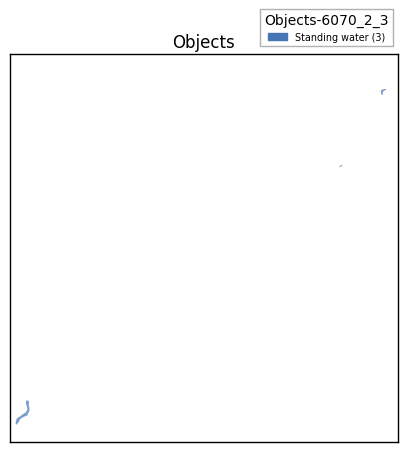

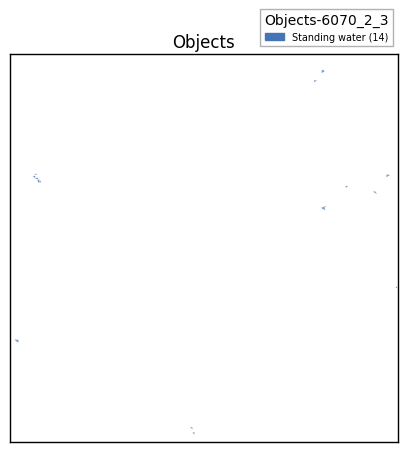

In [56]:
# prepare validaiton data
class_type = 8
val_image_id = ['6070_2_3']
val_x, val_y, val_p = image_to_train(image_id = val_image_id[0], class_type = class_type, image_type = 'withLabel')

# Plot original validation polygons
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:val_p}, figsize=(5,5))

# Plot predicted validation polygons - how well the model generaalizes
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[0], 
                                                     threshold = 0.3, image_type = 'withLabel')
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

print('jaccard score = {:.4e}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))

## 9_LargeVehicle

In [47]:
class_type = 9
val_image_id = ['6120_2_0']

# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => 6100_2_3 + 6120_2_2
val_image_id = ['6120_2_2', '6100_1_3', '6110_4_0', '6140_3_1', '6110_3_1', '6100_2_2']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')

# 3_Road data without labels
val_image_id = []
train_x_road, train_y_road = load_train_pixels(class_type = 3, val_ids = val_image_id, image_type = 'withLabel')
train_y_road = np.array([0] * len(train_y_road))

# 4_Track data without labels
val_image_id = []
train_x_track, train_y_track = load_train_pixels(class_type = 4, val_ids = val_image_id, image_type = 'withLabel')
train_y_track = np.array([0] * len(train_y_track))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_road, train_x_track))
train_y = np.hstack((train_y, train_y_wl, train_y_road, train_y_track))

del train_x_wl, train_y_wl, train_x_road, train_x_track, train_y_road, train_y_track


7 ['6120_2_2', '6100_1_3', '6110_4_0', '6140_3_1', '6100_2_3', '6110_3_1', '6100_2_2']
Loading data for class type 9
Data loaded in 49 seconds. (10473, 17) (10473,)
2 ['6120_2_0', '6100_2_3']
Loading data for class type 9
Data loaded in 19 seconds. (22742571, 17) (22742571,)
11 ['6120_2_2', '6120_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6070_2_3', '6100_2_2']
Loading data for class type 3
Data loaded in 79 seconds. (2356689, 17) (2356689,)
23 ['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2', '6110_3_1', '6170_2_4', '6170_4_1', '6170_0_4', '6060_2_3', '6010_1_2', '6040_4_4', '6100_2_2']
Loading data for class type 4
Data loaded in 172 seconds. (8596101, 17) (8596101,)


In [48]:
pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 9 finishied in 699 seconds...
Training AUC:  0.940626527611


In [7]:
## optimize threshold values

class_type = 9

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

# threshold = [0.03, 0.04, 0.05]
# Averaged Jaccard Score =  [0.014165086815163708, 0.02659500774314107, 0.01716351234110796]
threshold = [0.04]
jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4e}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


imageId = 6100_1_3, threshold = 0.0400, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.3312e-08
imageId = 6100_2_2, threshold = 0.0400, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.0744e-08
imageId = 6100_2_3, threshold = 0.0400, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.4799e-08


Self-intersection at or near point 949.66431924882625 3130.3779342723005


imageId = 6110_3_1, threshold = 0.0400, jaccard score = 3.0100e-02, InterArea = 5.0980e-09, UnionArea = 1.6937e-07
imageId = 6110_4_0, threshold = 0.0400, jaccard score = 3.8976e-02, InterArea = 2.2063e-09, UnionArea = 5.6605e-08
imageId = 6120_2_0, threshold = 0.0400, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.1435e-08
imageId = 6120_2_2, threshold = 0.0400, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 8.4794e-09
imageId = 6140_3_1, threshold = 0.0400, jaccard score = 6.7257e-02, InterArea = 4.4397e-10, UnionArea = 6.6011e-09
Averaged Jaccard Score =  [0.02659500774314107]


In [ ]:
# prepare validaiton data
val_image_id = ['6100_2_3']
val_x, val_y, val_p = image_to_train(image_id = val_image_id[0], class_type = class_type, image_type = 'withLabel')

# Plot original validation polygons
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:val_p}, figsize=(5,5))

# Plot predicted validation polygons - how well the model generaalizes
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[0], 
                                                     threshold = 0.04, image_type = 'withLabel')
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

print('jaccard score = {:.4f}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))

## 10_SmallVehicle

In [50]:
class_type = 10
val_image_id = ['6120_2_0']

# data with labels
train_x, train_y = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withLabel')

# data without labels => ‘6070_2_3’ + ‘6100_2_3’ + '6120_2_2'
val_image_id = ['6110_1_2', '6120_2_0', '6090_2_0', '6100_1_3', '6110_4_0', '6140_3_1', 
                '6140_1_2', '6110_3_1', '6060_2_3', '6100_2_2']
train_x_wl, train_y_wl = load_train_pixels(class_type = class_type, val_ids = val_image_id, image_type = 'withoutLabel')

# 3_Road data without labels
val_image_id = []
train_x_road, train_y_road = load_train_pixels(class_type = 3, val_ids = val_image_id, image_type = 'withLabel')
train_y_road = np.array([0] * len(train_y_road))

# 4_Track data without labels
val_image_id = []
train_x_track, train_y_track = load_train_pixels(class_type = 4, val_ids = val_image_id, image_type = 'withLabel')
train_y_track = np.array([0] * len(train_y_track))

# stack the data
train_x = np.vstack((train_x, train_x_wl, train_x_road, train_x_track))
train_y = np.hstack((train_y, train_y_wl, train_y_road, train_y_track))

del train_x_wl, train_y_wl, train_x_road, train_x_track, train_y_road, train_y_track



12 ['6120_2_2', '6090_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6060_2_3', '6070_2_3', '6100_2_2']
Loading data for class type 10
Data loaded in 87 seconds. (55103, 17) (55103,)
3 ['6120_2_2', '6100_2_3', '6070_2_3']
Loading data for class type 10
Data loaded in 25 seconds. (33891350, 17) (33891350,)
11 ['6120_2_2', '6120_2_0', '6100_1_3', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6140_1_2', '6110_3_1', '6070_2_3', '6100_2_2']
Loading data for class type 3
Data loaded in 79 seconds. (2356689, 17) (2356689,)
23 ['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3', '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1', '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2', '6110_3_1', '6170_2_4', '6170_4_1', '6170_0_4', '6060_2_3', '6010_1_2', '6040_4_4', '6100_2_2']
Loading data for class type 4
Data loaded in 172 seconds. (8596101, 17) (8596101,)


In [51]:
pipeline = make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators = 100))
start = time.time()
print('training...')
pipeline.fit(train_x, train_y)

clfs = joblib.load('clfs_17Bands.pkl')
clfs[class_type] = pipeline
joblib.dump(clfs, 'clfs_17Bands.pkl')

print('training for class type %d finishied in %d seconds...' % (class_type, time.time()-start))
        
## Show model accuracy: Use AUC because single class is a skwed binary classfication where AUC works better.
pred_train_y = clfs[class_type].predict_proba(train_x)[:,1]

print ("Training AUC: ", roc_auc_score(y_true = train_y, y_score = pred_train_y))

training...
training for class type 10 finishied in 955 seconds...
Training AUC:  0.866675177613


In [6]:
## optimize threshold values
class_type = 10

clfs = joblib.load('clfs_17Bands.pkl')

val_image_id = train_wkt[(train_wkt['ClassType']==class_type) 
          & (train_wkt['MultipolygonWKT']!='MULTIPOLYGON EMPTY')].ImageId.unique().tolist()
val_image_id = sorted(val_image_id)

# Averaged Jaccard Score =  [ 0.003492237335016998, 0.003821405967521134, 0.003745675344254813]
# threshold =[0.016, 0.017, 0.018]

threshold = [0.017]
jaccard_list = []
for i in threshold:
    areaInter = 0
    areaUnion = 0
    for j in range(len(val_image_id)):
        # prepare validaiton data
        val_x, val_y, val_p = image_to_train(image_id = val_image_id[j], 
                                             class_type = class_type, image_type = 'withLabel')

        # Plot original validation polygons
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:val_p}, figsize=(5,5))

        # Plot predicted validation polygons - how well the model generaalizes
        pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[j], 
                                                             threshold = i, image_type = 'withLabel')
        # plot_polygons(image_id = val_image_id[j], polygonsList = {class_type:pred_val_p}, figsize=(5,5))
        
        print('imageId = {:^8}, threshold = {:.4f}, jaccard score = {:.4e}, InterArea = {:.4e}, UnionArea = {:.4e}'
              .format(val_image_id[j], i, pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area, 
                pred_val_p.intersection(val_p).area, pred_val_p.union(val_p).area))
                
        areaInter += pred_val_p.intersection(val_p).area 
        areaUnion += pred_val_p.union(val_p).area
        
    jaccard_list.append(areaInter/areaUnion)
    
print('Averaged Jaccard Score = ', jaccard_list)  


imageId = 6060_2_3, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 2.6350e-10
imageId = 6070_2_3, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 4.7600e-09
imageId = 6090_2_0, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 6.6226e-10
imageId = 6100_1_3, threshold = 0.0170, jaccard score = 5.0206e-03, InterArea = 2.6650e-10, UnionArea = 5.3082e-08
imageId = 6100_2_2, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 2.0035e-08
imageId = 6100_2_3, threshold = 0.0170, jaccard score = 4.0949e-02, InterArea = 2.4939e-09, UnionArea = 6.0901e-08


Self-intersection at or near point 1960.6605922551253 938.5603644646925


imageId = 6110_1_2, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 2.1216e-07


Self-intersection at or near point 1237.3829787234042 2274.9787234042551


imageId = 6110_3_1, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.4798e-07


Self-intersection at or near point 2864.8188679245281 476.37358490566038


imageId = 6110_4_0, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 4.9254e-08
imageId = 6120_2_0, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 3.3690e-09
imageId = 6120_2_2, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 1.2969e-07
imageId = 6140_1_2, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 7.1045e-09
imageId = 6140_3_1, threshold = 0.0170, jaccard score = 0.0000e+00, InterArea = 0.0000e+00, UnionArea = 3.2221e-08
Averaged Jaccard Score =  [0.0038259648919112318]


In [ ]:
# Plot original validation polygons
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:val_p}, figsize=(5,5))

# Plot predicted validation polygons - how well the model generaalizes
pred_val_y, pred_val_wkt, pred_val_p = predict_class(clf = clfs[class_type], image_id = val_image_id[0], 
                                                     threshold = 0.017, image_type = 'withLabel')
plot_polygons(image_id = val_image_id[0], polygonsList = {class_type:pred_val_p}, figsize=(5,5))

print('jaccard score = ', pred_val_p.intersection(val_p).area / pred_val_p.union(val_p).area)

# Predict

In [ ]:
# load the model
clfs = joblib.load('clfs_17Bands.pkl')

# prepare test image ids
submission_list = sample_submission.ImageId.unique()
train_list = train_wkt.ImageId.unique()

test_image_ids = []
for i in submission_list:
    if i not in train_list:
        test_image_ids.append(i)
test_image_ids = sorted(test_image_ids)

# threshold_list = [0.27, 0.032, 0.0162, 0.044, 0.15, 0.3, 0.304, 0.2, 0.0001, 0.001]
threshold_list = [0.4, 0.07, 0.31, 0.1, 0.6, 0.4, 0.34, 0.3, 0.04, 0.017]

# predict the test images
sub = []
preds = dict()
for image_id in test_image_ids:
    for clf in clfs:
        print (image_id,'=>', clf)
        pred_y, pred_wkt, pred_p = predict_class(image_id, clfs[clf], image_type = '17',
                                                 threshold = threshold_list[clf-1])
        preds[clf] = (pred_y, pred_wkt, pred_p)
        sub.append([image_id, clf,pred_wkt])

joblib.dump(sub, 'sub_17Bands_Pixel.pkl')

# Submission

In [7]:
sub = joblib.load('sub_17Bands_Pixel.pkl')
sample_submission_new = pd.read_csv('./sample_submission_new.csv')

pd_sub = pd.DataFrame(sub, columns = ['ImageId','ClassType','MultipolygonWKT'])

## This step is to ensure output will have the same sequence as sample submission
pd_output = pd.merge(sample_submission_new, pd_sub, how = 'left', on = ['ImageId','ClassType'])
pd_output = pd_output.fillna(-999)

## In the case empty multipolygons were predicted, use default polygons from sample submission
pd_output ['MultipolygonWKT'] = pd_output[['MultipolygonWKT_x','MultipolygonWKT_y']].apply(
    lambda x:x[0] if x[1] == -999 else x[1],axis=1)

# fix submission issues
#pd_output['MultipolygonWKT'] = pd_output['MultipolygonWKT'].\
#apply(lambda x:x.simplify(1e-8, preserve_topology=False)).\
#apply(lambda x:x if x.is_valid else x.buffer(0)).\
#apply(lambda x:shapely.wkt.dumps(x,rounding_precision=8))   

pd_output[['ImageId','ClassType','MultipolygonWKT']].to_csv("./output.csv", index = False)